**Correlation Greeks**

9 May 2021

In [129]:
import numpy as np
import random
import time
from matplotlib import pyplot as plt

## Auxiliary functions

In [81]:
def check_forward_reverse_mode_identity(diff_u_list=[], u_bar_list=[], diff_A_list=[], A_bar_list = [],
                                       diff_v_list =[], v_bar_list=[], diff_B_list=[], B_bar_list = []):
    # diff_u_list, u_bar_list is a list of input np arrays
    # diff_A_list, A_bar_list is a list of input nd arrays representing the input matrices 
    # diff_v_list, v_bar_list is a list of output np arrays
    # diff_B_list, B_bar_list is a list of output nd arrays representing the output matrices 
    # to do: assert that the dimension of u_list and u_bar_list as well as A_list and A_bar_list is the same
    sum_lhs = 0
    for diff_u, u_bar in zip(diff_u_list, u_bar_list):
        sum_lhs += np.dot(u_bar, diff_u)
    for diff_A, A_bar in zip(diff_A_list, A_bar_list):
        sum_lhs += np.trace(A_bar.transpose() @ diff_A)
    sum_rhs = 0
    for diff_v, v_bar in zip(diff_v_list, v_bar_list):
        sum_rhs += np.dot(v_bar, diff_v)
    for diff_B, B_bar in zip(diff_B_list, B_bar_list):
        sum_rhs += np.trace(B_bar.transpose() @ diff_B)
    #print(sum_lhs, sum_rhs)
    err = abs(sum_lhs - sum_rhs)
    
    return err < 10e-15, err

In [82]:
def check_symmetric(A, rtol=1e-05, atol=1e-08):
    return np.allclose(A, A.T, rtol=rtol, atol=atol)

## Cholesky decomposition

In [83]:
# input parameters
d = 5
A = np.identity(d)
#corr = 1
for i in range(d):
    for j in range(i):
        #corr -= 0.04
        A[i][j] = 0.1
        A[j][i] = 0.1

In [84]:
# check symmetry 
print("The input matrix is symmetric: ", check_symmetric(A))

The input matrix is symmetric:  True


In [85]:
# forward pass
def cholesky_decomposition(A, complexA = False):
    d = A.shape[0]
    if complexA == True:
        A_copy = A.astype(dtype=complex)
        L = np.zeros((d,d), dtype=complex)
    else:
        A_copy = np.ndarray.copy(A)
        L = np.zeros((d,d))
    for i in range(d):
        for j in range(i+1):
            for k in range(j):
                A_copy[i][j] = A_copy[i][j] - L[i][k]*L[j][k]
            if j == i:
                L[i][i] = np.sqrt(A_copy[i][i])
            else:
                L[i][j] = A_copy[i][j]/L[j][j]
    assert(np.allclose(A, np.dot(L, L.transpose()), rtol = 10e-15, atol =10e-15)), "L*L^T != A"
    
    return L

In [86]:
# check Cholesky factorisation
L_true = cholesky_decomposition(A)
L_estimated = np.linalg.cholesky(A)

print("The Cholesky factorisation is correct: ", np.allclose(L_true, L_estimated, rtol = 10e-15, atol = 10e-15))

The Cholesky factorisation is correct:  True


In [87]:
# forward mode 
def cholesky_decomposition_forward(A, diff_A):
    # to do: check that A is symmetric, A and and has exactly two values being 1 (all the other being 0)
    # to do: check A and diff_A have the same dimensions
    d = A.shape[0]
    A_copy = np.ndarray.copy(A)
    diff_A_copy = np.ndarray.copy(diff_A)
    L = np.zeros((d,d))
    diff_L = np.zeros((d, d))
    for i in range(d):
        for j in range(i+1):
            for k in range(j):
                diff_A_copy[i][j] = diff_A_copy[i][j] - diff_L[i][k]*L[j][k] - L[i][k]*diff_L[j][k]
                A_copy[i][j] = A_copy[i][j] - L[i][k]*L[j][k]
            if j == i:
                #diff_L[i][i] = 0.5 * diff_A_copy[i][i] / np.sqrt(A_copy[i][i])
                #L[i][i] = np.sqrt(A_copy[i][i])
                L[i][i] = np.sqrt(A_copy[i][i])
                diff_L[i][i] = 0.5 * diff_A_copy[i][i] / L[i][i]
            else:
                diff_L[i][j] = diff_A_copy[i][j] / L[j][j] - (A_copy[i][j] * diff_L[j][j]) / L[j][j]**2
                L[i][j] = A_copy[i][j] / L[j][j]
    assert(np.allclose(A, np.dot(L, L.transpose()), rtol = 10e-15, atol =10e-15)), "L*L^T != A"

    return L, diff_L

In [88]:
# reverse mode
# note: no need of cholesky_decomposition_f, since we do not need intermediate values for the reverse mode of Cholesky decomposition
def cholesky_decomposition_b(L, L_bar):
    d = L.shape[0]
    A_bar = np.zeros((d,d))
    L_bar_copy = np.ndarray.copy(L_bar)
    for i in reversed(range(d)):
        for j in reversed(range(i+1)):
            if i == j:
                A_bar[i][i] = 0.5*L_bar_copy[i][i]/L[i][i]
            else:
                A_bar[i][j] = L_bar_copy[i][j]/L[j][j]
                L_bar_copy[j][j] = L_bar_copy[j][j] - L_bar_copy[i][j] * L[i][j] / L[j][j]
            for k in reversed(range(j)):
                L_bar_copy[i][k] = L_bar_copy[i][k] - A_bar[i][j] * L[j][k]
                L_bar_copy[j][k] = L_bar_copy[j][k] - A_bar[i][j] * L[i][k]
    return A_bar

def cholesky_decomposition_reverse(A, L_bar):
    # forward pass 
    L =  cholesky_decomposition(A)
    # backward pass 
    A_bar = cholesky_decomposition_b(L, L_bar)
    return L, A_bar



### Validation of sensitivities
consider sensitivity of the correlation of stock s1 and stock s2

In [89]:
# input parameter
s1 = 1 # smaller than s2
s2 = 2
assert(s1 < s2)

In [90]:
# bumping
epsilon = 10e-6

A_minus = np.ndarray.copy(A)
A_minus[s2][s1] -= epsilon
A_minus[s1][s2] -= epsilon
A_plus = np.ndarray.copy(A)
A_plus[s2][s1] += epsilon 
A_plus[s1][s2] += epsilon
s1_s2_corr_sensivity_bumping = (cholesky_decomposition(A_plus) - cholesky_decomposition(A_minus)) / (2*epsilon)

In [91]:
# complex variable trick
epsilon = 10e-20
        
A_epsilon = A.astype(complex)
A_epsilon[s2][s1] += epsilon * 1j
#A_epsilon[s1][s2] += epsilon * 1j
            
s1_s2_corr_sensitivity_complex_trick = (cholesky_decomposition(A_epsilon, complexA=True)).imag / epsilon
print("""the difference between the sensivity approximation of corr_s1_s2 using bumping and the complex 
variable trick is""", np.linalg.norm(s1_s2_corr_sensivity_bumping - s1_s2_corr_sensitivity_complex_trick))

the difference between the sensivity approximation of corr_s1_s2 using bumping and the complex 
variable trick is 1.014787152056842e-11


In [92]:
# check forward mode
diff_A = np.zeros((d, d))
diff_A[s2][s1] = 1
# diff_A[s1][s2] = 1
L, diff_L  = cholesky_decomposition_forward(A, diff_A)
print("""Difference of forward mode to the complex variable trick is: """,
        np.linalg.norm(diff_L - s1_s2_corr_sensitivity_complex_trick))

Difference of forward mode to the complex variable trick is:  1.9873754096201566e-17


In [93]:
# check reverse mode
diff_A = np.tril(np.random.rand(d,d)) # since A is symmetric, the cholesky decomposition defines a mapping from
                                      # the lower-triangular part of A to L. 
                                      # Thus, diff_A is lower triangular matrix.
L_bar = np.random.rand(d, d)*2 - 1 # uniform samples in [-1, 1]

L, diff_L = cholesky_decomposition_forward(A, diff_A)
L, A_bar = cholesky_decomposition_reverse(A, L_bar)

b, err = check_forward_reverse_mode_identity([], [] ,[diff_A], [A_bar], [], [], [diff_L], [L_bar])
print("The forward/ reverse mode identity holds: ", b)

The forward/ reverse mode identity holds:  True


In [94]:
# check the function that checks the standard forward / reverse mode identity
sum1 = 0
sum2 = 0
for i in range(d):
    for j in range(i+1):
        sum1 += A_bar[i][j] * diff_A[i][j]
        sum2 += L_bar[i][j] * diff_L[i][j]
err_true = abs(sum1 - sum2)/2
print('The function check_forward_reverse_mode_identity is correct: ', abs(err_true - err) < 10e-16)

The function check_forward_reverse_mode_identity is correct:  True


## GBM
The payoff function is given by 
$$ P(s) = \sum_{i=1}^d S_i. $$

In [95]:
# input parameters
S0 = np.ones(d) # initial value
r = 0.05
N = 10 # number of time steps
M = 100 # number of path simulations
T = 1
h = T/N

In [96]:
# forward pass
def gbm_path_simulation(L, L_complex = False):
    d = L.shape[0]
    if L_complex:
        S = S0.astype(dtype=complex)
    else:
        S = np.ndarray.copy(S0)
    for n in range(N):
        Z_n = np.random.normal(size = d)
        Z = np.dot(L, Z_n)
        for i in range(d):
            S[i] = S[i] * (1 + r*h + np.sqrt(h)*Z[i])
    return S

def gbm_path_simulation_f(L):
    d = L.shape[0]
    Z_list = []
    Z_n_list = []
    S_list = [S0]
    S = np.ndarray.copy(S0)
    for n in range(N):
        Z_n = np.random.normal(size = d)
        Z = np.dot(L, Z_n)
        for i in range(d):
            S[i] = S[i] * (1 + r*h + np.sqrt(h)*Z[i])
        Z_list.append(Z), Z_n_list.append(Z_n), S_list.append(np.copy(S)) # do not forget copy here, otherwise 
                                                                          # the list will have the same value
    return S_list, Z_n_list, Z_list

def avg_payoff(L, payoff_fct = sum, L_complex = False):
    avg = 0
    for m in range(M):
        S = gbm_path_simulation(L, L_complex)
        payoff = payoff_fct(S)
        avg += payoff
    avg /= M
    # to do: discounting
    return avg

# Used for the full AD approach
def avg_payoff_f(L, M, payoff_fct = sum):
    S_all_list = []
    Z_n_all_list = []
    Z_all_list = []
    avg = 0
    for m in range(M):
        S_list, Z_n_list, Z_list = gbm_path_simulation_f(L)
        S_all_list.append(S_list), Z_n_all_list.append(Z_n_list), Z_all_list.append(Z_list)
        payoff = payoff_fct(S)
        avg += payoff
    avg /= M
    return S_all_list, Z_n_all_list, Z_all_list

In [97]:
# forward mode 
def gbm_path_simulation_forward(L, diff_L):
    d = L.shape[0]
    S = np.ndarray.copy(S0)
    diff_S = np.zeros(d)
    for n in range(N):
        Z_n = np.random.normal(size = d)
        diff_Z = np.dot(diff_L, Z_n)
        Z = np.dot(L, Z_n)
        for i in range(d):
            diff_S[i] = diff_S[i] * (1 + r*h + np.sqrt(h)*Z[i]) + S[i] * np.sqrt(h) * diff_Z[i]
            S[i] = S[i] * (1 + r*h + np.sqrt(h)*Z[i])
    return S, diff_S

def avg_payoff_forward(L, diff_L, payoff_fct = sum, diff_payoff_fct = sum):  
    diff_avg = 0 
    avg = 0
    for m in range(M):
        S , diff_S = gbm_path_simulation_forward(L, diff_L)
        diff_payoff = diff_payoff_fct(diff_S)
        payoff = payoff_fct(S)
        diff_avg += diff_payoff
        avg += payoff
    diff_avg /= M
    avg /= M
    return avg, diff_avg

In [98]:
# reverse mode
def gbm_path_simulation_b(S_list, Z_n_list, Z_list, S_bar):
    d = Z_list[0].shape[0]
    S_bar_copy = np.copy(S_bar)
    Z_bar = np.zeros(d)
    L_bar = np.zeros(d)
    for n in reversed(range(N)):
        S = S_list[n]
        Z_n = Z_n_list[n]
        Z = Z_list[n]
        for i in reversed(range(d)):
            Z_bar[i] =  S[i]*np.sqrt(h) * S_bar_copy[i]
            S_bar_copy[i] = (1 + r*h + np.sqrt(h)*Z[i]) * S_bar_copy[i]
        L_bar = L_bar + np.outer(Z_bar, Z_n) # computes multiplication of dx1 and 1xd vector to obtain dxd matrix
    return L_bar 
            
def gbm_path_simulation_reverse(L, S_bar):
    # forward pass
    S_list, Z_n_list, Z_list = gbm_path_simulation_f(L)
    # backward pass
    L_bar = gbm_path_simulation_b(S_list, Z_n_list, Z_list, S_bar)
    return L_bar

def avg_payoff_reverse(L, M, avg_bar):
    L_bar = np.zeros((d,d))
    avg_bar /= M 
    for m in range(M):
        S_bar = np.ones(d) * avg_bar 
        L_bar_path = gbm_path_simulation_reverse(L, S_bar) # do forward and reverse pass along one path
        L_bar += L_bar_path
    return L_bar

# # random seed approach
# def avg_payoff_reverse(L, M, avg_bar):
#     L_bar = np.zeros((d,d))
#     avg_bar /= M 
#     for m in range(M):
#         rdm_state = np.random.get_state()
#         for i in reversed(range(d)):
#             np.random.set_state(rdm_state)
#             S_bar = np.zeros(d)
#             S_bar[i] += 1 # initilizes S_bar = e_i
#             L_bar_path = gbm_path_simulation_reverse(L, S_bar) # do forward and reverse pass along one path
#             L_bar += L_bar_path * avg_bar 
        
#     return L_bar

In [99]:
# reverse mode, pedantic approach with M simulations
def avg_payoff_b(S_all_list, Z_n_all_list, Z_all_list, M, avg_bar):
    d = Z_all_list[0][0].shape[0]
    L_bar = np.zeros(d)
    avg_bar /= M
    for m in reversed(range(M)):
        Z_bar = np.zeros(d)
        S_bar = np.ones(d)*avg_bar
        for n in reversed(range(N)):
            S = S_all_list[m][n]
            Z_n = Z_n_all_list[m][n]
            Z = Z_all_list[m][n]
            for i in reversed(range(d)):
                Z_bar[i] =  S[i]*np.sqrt(h) * S_bar[i]
                S_bar[i] = (1 + r*h + np.sqrt(h)*Z[i]) * S_bar[i]
            L_bar = L_bar + np.outer(Z_bar, Z_n)
        #print(L_bar)
    return L_bar 


def avg_payoff_reverse_pedantic(L, M, avg_bar):
    # forward pass 
    S_all_list, Z_n_all_list, Z_all_list = avg_payoff_f(L, M)
    # backward pass
    L_bar = avg_payoff_b(S_all_list, Z_n_all_list, Z_all_list, M, avg_bar)
    return L_bar
        

### Validation of sensitivities



In [100]:
# bumping 
epsilon = 10e-6

np.random.seed(100)
L_minus = np.ndarray.copy(L)
L_minus[s2][s1] -= epsilon
S_minus = gbm_path_simulation(L_minus)
avg_minus = avg_payoff(L_minus)

np.random.seed(100)
L_plus = np.ndarray.copy(L)
L_plus[s2][s1] += epsilon 
S_plus = gbm_path_simulation(L_plus)
avg_plus = avg_payoff(L_plus)

path_sensitivity_wrt_L_s1_s2_bumping = (S_plus - S_minus) / (2*epsilon)
payoff_sensitivity_wrt_L_s1_s2_bumping = (avg_plus-avg_minus) / (2*epsilon)


In [101]:
# complex variable trick
epsilon = 10e-20
        
L_epsilon = L.astype(complex)
L_epsilon[s2][s1] += epsilon * 1j
            
np.random.seed(100)
path_sensitivity_wrt_L_s1_s2_complex_trick = gbm_path_simulation(L_epsilon, L_complex = True).imag / epsilon
payoff_sensitivity_wrt_L_s1_s2_complex_trick = avg_payoff(L_epsilon, L_complex = True).imag / epsilon
print("""path sensitivity: Difference between bumping and complex variable trick is """, 
      np.linalg.norm(path_sensitivity_wrt_L_s1_s2_bumping - path_sensitivity_wrt_L_s1_s2_complex_trick))
print("""payoff sensitivity: Difference between bumping and complex variable trick is """, 
      np.linalg.norm(payoff_sensitivity_wrt_L_s1_s2_bumping - payoff_sensitivity_wrt_L_s1_s2_complex_trick))


path sensitivity: Difference between bumping and complex variable trick is  9.76518865769549e-12
payoff sensitivity: Difference between bumping and complex variable trick is  2.2826157630717603e-11


In [102]:
# check forward mode 
np.random.seed(100)

diff_L = np.zeros((d,d))
diff_L[s2][s1] = 1
S, diff_S = gbm_path_simulation_forward(L, diff_L)
print("""path sensitivity: Difference between complex variable trick and forward mode""", 
     np.linalg.norm(path_sensitivity_wrt_L_s1_s2_complex_trick - diff_S))
avg, diff_avg = avg_payoff_forward(L, diff_L)
print("""payoff sensitivity: Difference between complex variable trick and forward mode""", 
     np.linalg.norm(payoff_sensitivity_wrt_L_s1_s2_complex_trick - diff_avg))


path sensitivity: Difference between complex variable trick and forward mode 5.551115123125783e-17
payoff sensitivity: Difference between complex variable trick and forward mode 1.3877787807814457e-16


In [103]:
# check reverse mode
S_bar = np.random.rand(d)
#S_bar = np.ones(d)
avg_bar = np.random.rand()
#avg_bar = 1
diff_L = np.random.rand(d, d)
#diff_L = np.zeros((d,d))
#diff_L[s2][s1] = 1


np.random.seed(100)
S, diff_S = gbm_path_simulation_forward(L, diff_L)
avg, diff_avg = avg_payoff_forward(L, diff_L)

np.random.seed(100)
L_bar_path = gbm_path_simulation_reverse(L, S_bar)
# L_bar_payoff_pedantic = avg_payoff_reverse_pedantic(L, M, avg_bar)
L_bar_payoff = avg_payoff_reverse(L, M, avg_bar)

b, err = check_forward_reverse_mode_identity([], [] ,[diff_L], [L_bar_path], [diff_S], [S_bar], [], [])
print("The forward/ reverse mode identity for the path calculation holds: ", b)

b, err = check_forward_reverse_mode_identity([], [] ,[diff_L], [L_bar_payoff], [diff_avg], [avg_bar], [], [])
print("The forward/ reverse mode identity for the payoff calculation holds: ", b)

The forward/ reverse mode identity for the path calculation holds:  True
The forward/ reverse mode identity for the payoff calculation holds:  True


In [104]:
# check that the function for the forward/ reverse mode identity holds
lhs = np.trace(L_bar_path.transpose() @ diff_L)
rhs = np.dot(diff_S, S_bar)
print(lhs, rhs)

lhs = np.trace(L_bar_payoff.transpose() @ diff_L)
rhs = avg_bar * diff_avg
print(lhs, rhs)


-1.929606570320611 -1.929606570320611
0.31563454007027497 0.3156345400702749


## Workflow: Cholesky decomposition and GBM  

In [105]:
# forward pass
def correlation_greeks(A, complexA = False):
    L = cholesky_decomposition(A, complexA)
    avg = avg_payoff(L, L_complex = complexA)
    return avg

def correlation_greeks_f(A):
    rdm_state = []
    # rdm_state.append(np.random.get_state()) # not necessary here as Cholesky decomposition is not random
    L = cholesky_decomposition(A)
    rdm_state.append(np.random.get_state())
    avg = avg_payoff(L)
    return avg, L, rdm_state

In [106]:
# forward mode
def correlation_greeks_forward(A, diff_A):
    L, diff_L = cholesky_decomposition_forward(A, diff_A)
    agv, diff_avg = avg_payoff_forward(L, diff_L)
    return avg, diff_avg

In [107]:
# reverse mode

# full Monte Carlo approach 
def correlation_greeks_b_MC(avg_bar, L, rdm_state):
    np.random.set_state(rdm_state.pop())
    A_bar_path_list = []
    S_bar = np.ones(d) * avg_bar # given from the payoff
    for m in range(M):
        L_bar_path = gbm_path_simulation_reverse(L, S_bar) #checkpointing, since I have not saved relevant S, Z, Z_n in the forward step
        A_bar_path = cholesky_decomposition_b(L, L_bar_path)
        A_bar_path_list.append(A_bar_path)
    
    mean_A_bar = np.mean(A_bar_path_list, axis=0)
    std_A_bar = np.std(A_bar_path_list, axis=0)
    #print("MC:")
    #print(std_A_bar)
    lower_bound = mean_A_bar-3*std_A_bar/np.sqrt(M)
    upper_bound = mean_A_bar+3*std_A_bar/np.sqrt(M)
    
    return mean_A_bar, [lower_bound, upper_bound] 

def correlation_greeks_reverse_MC(A, avg_bar):
    avg, L, rdm_state = correlation_greeks_f(A)
    mean_A_bar, [lower_bound, upper_bound]  = correlation_greeks_b_MC(avg_bar, L, rdm_state)
    return avg, (mean_A_bar, (lower_bound, upper_bound))

# binning
def correlation_greeks_b_binning(avg_bar, L, K, rdm_state):
    np.random.set_state(rdm_state.pop())
    nbr_paths_per_batch = int(M/K)
    A_bar_list = []

    for batch in range(K):
        L_bar = avg_payoff_reverse(L, nbr_paths_per_batch, avg_bar) #checkpointing, since I have not saved relevant S, Z, Z_n in the forward step
        A_bar = cholesky_decomposition_b(L, L_bar)
        A_bar_list.append(A_bar)

    mean_A_bar = np.mean(A_bar_list, axis=0)
    std_A_bar = np.std(A_bar_list, axis=0)
    #print("binning:")
    #print(std_A_bar)
    lower_bound = mean_A_bar - 3*std_A_bar/np.sqrt(K)
    upper_bound = mean_A_bar + 3*std_A_bar/np.sqrt(K)
    
    return mean_A_bar, [lower_bound, upper_bound]

def correlation_greeks_reverse_binning(A, avg_bar, K):
    avg, L, rdm_state = correlation_greeks_f(A)
    mean_A_bar, [lower_bound, upper_bound]  = correlation_greeks_b_binning(avg_bar, L, K, rdm_state)
    return avg, (mean_A_bar, (lower_bound, upper_bound))


### Validation of sensitivities

In [108]:
# complex variable trick
epsilon = 10e-20
        
A_epsilon = A.astype(complex)
A_epsilon[s2][s1] += epsilon * 1j
            
np.random.seed(100)
payoff_sensitivity_wrt_s1_s2_complex_trick = correlation_greeks(A_epsilon, complexA=True).imag / epsilon

In [109]:
# check forward mode 
diff_A = np.zeros((d,d))
diff_A[s2][s1] = 1

np.random.seed(100)
avg, diff_avg = correlation_greeks_forward(A, diff_A)
print("""payoff sensitivity: Difference between complex variable trick and forward mode""", 
     np.linalg.norm(payoff_sensitivity_wrt_s1_s2_complex_trick - diff_avg))


payoff sensitivity: Difference between complex variable trick and forward mode 8.326672684688674e-17


In [110]:
# check correlation greeks
K = 20
avg_bar = 1
#diff_A = np.tril(np.random.rand(d,d))
diff_A = np.zeros((d,d))
diff_A[s2][s1] = 1

# forward mode 
np.random.seed(100)
avg, diff_avg = correlation_greeks_forward(A, diff_A)

# reverse mode

# standard AD - no confidence interval for the sensitivity of the price
np.random.seed(100)
avg, L, rdm_state = correlation_greeks_f(A)
np.random.set_state(rdm_state.pop())
L_bar = avg_payoff_reverse(L, M, avg_bar) 
A_bar = cholesky_decomposition_b(L, L_bar)
#print(A_bar)

# Monte-Carlo approach
np.random.seed(100)
avg_MC, A_bar_MC = correlation_greeks_reverse_MC(A, avg_bar)
#print(A_bar_MC[0])

# binning
np.random.seed(100)
avg_binning, A_bar_binning = correlation_greeks_reverse_binning(A, avg_bar, K)
#print(A_bar_binning[0])


b, err = check_forward_reverse_mode_identity([], [], [diff_A], [A_bar], [diff_avg], [avg_bar], [], [])
print("The forward/ reverse mode identity for the standard AD calculation holds: ", b)

b, err = check_forward_reverse_mode_identity([], [], [diff_A], [A_bar_MC[0]], [diff_avg], [avg_bar], [], [])
print("The forward/ reverse mode identity for the Monte-Carlo approach holds: ", b)

b, err = check_forward_reverse_mode_identity([], [], [diff_A], [A_bar_binning[0]], [diff_avg], [avg_bar], [], [])
print("The forward/ reverse mode identity for the binning approach holds: ", b)

The forward/ reverse mode identity for the standard AD calculation holds:  True
The forward/ reverse mode identity for the Monte-Carlo approach holds:  True
The forward/ reverse mode identity for the binning approach holds:  True


In [112]:
print('The mean of A_bar_MC is: \n', A_bar_MC[0])
print("The 3 std confidence interval has lower bound: \n",A_bar_MC[1][0])
print("The 3 std confidence interval has upper bound: \n", A_bar_MC[1][1])
print("----------------------------")
print('The mean of A_bar is: \n', A_bar_binning[0])
print("The 3 std confidence interval has lower bound: \n",A_bar_binning[1][0])
print("The 3 std confidence interval has upper bound: \n", A_bar_binning[1][1])

The mean of A_bar_MC is: 
 [[ 0.14077218  0.          0.          0.          0.        ]
 [-0.08459763 -0.05850068  0.          0.          0.        ]
 [-0.12711254  0.17719069  0.01626612  0.          0.        ]
 [-0.00439464  0.02550955  0.27959782  0.04470479  0.        ]
 [ 0.02800735  0.02398908  0.00970478 -0.14105328 -0.08702867]]
The 3 std confidence interval has lower bound: 
 [[-0.25758051  0.          0.          0.          0.        ]
 [-0.60640169 -0.29194673  0.          0.          0.        ]
 [-0.6009961  -0.30197919 -0.19202275  0.          0.        ]
 [-0.43791846 -0.41279176 -0.22540821 -0.40044875  0.        ]
 [-0.42562031 -0.31806057 -0.31346955 -0.58068132 -0.32450267]]
The 3 std confidence interval has upper bound: 
 [[0.53912487 0.         0.         0.         0.        ]
 [0.43720643 0.17494536 0.         0.         0.        ]
 [0.34677101 0.65636058 0.22455498 0.         0.        ]
 [0.42912918 0.46381087 0.78460386 0.48985833 0.        ]
 [0.4816350

In [113]:
-0.04836703 / -0.04220297

1.146057493110082

In [114]:
np.sqrt(5)

2.23606797749979

In [115]:
0.00228254 / 0.00088641

2.5750386390045237

In [116]:
-0.00573989 / -0.00434376

1.3214104830837798

In [117]:
-0.00205972 / -0.00164551

1.2517213508274032

In [118]:
0.00559571 / 0.0051815

1.0799401717649328

Unclear why the confidence interval should differ between the MC and the binning approach. 

## Execution time comparison 

In [162]:
d_list = [1,2,4, 6, 8,10,12,14, 16]

In [163]:
def correlation_greeks_reverse(A):
    np.random.seed(100)
    avg, L, rdm_state = correlation_greeks_f(A)
    np.random.set_state(rdm_state.pop())
    L_bar = avg_payoff_reverse(L, M, avg_bar) 
    A_bar = cholesky_decomposition_b(L, L_bar)
    return A_bar

def correlation_greeks_forward_all(A):
    d = A.shape[0]
    diff_res = np.zeros((d,d))
    for s1 in range(d):
        for s2 in range(s1+1):
            diff_A = np.zeros((d,d))
            diff_A[s1][s2] = 1
            np.random.seed(100)
            avg, diff_avg = correlation_greeks_forward(A, diff_A)
            diff_res[s1][s2] = diff_avg
    return diff_res
            

In [164]:
time_forward_all = []
time_reverse_all = []
for d in d_list:
    A = np.identity(d)
    for i in range(d):
        for j in range(i):
            A[i][j] = 0.1
            A[j][i] = 0.1
    
    S0 = np.ones(d) # initial value
    
    start_time = time.time()
    correlation_greeks_forward_all(A)
    end_time = time.time()
    time_forward_all.append(end_time-start_time)
    
    start_time = time.time()
    correlation_greeks_reverse(A)
    end_time = time.time()
    time_reverse_all.append(end_time - start_time)
time_forward_all = np.array(time_forward_all) / time_forward_all[0]
time_reverse_all = np.array(time_reverse_all) / time_reverse_all[0]

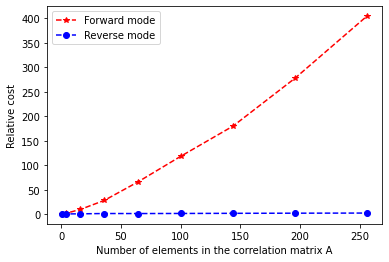

In [167]:
plt.plot(nbr_el_A, time_forward_all, linestyle='--', marker='*', color='r')
plt.plot(nbr_el_A, time_reverse_all, linestyle='--', marker='o', color='b')
plt.legend(["Forward mode", "Reverse mode"])
plt.xlabel('Number of elements in the correlation matrix A')
plt.ylabel("Relative cost")
# plt.yscale('log')
plt.savefig('forward_reverse.png')
plt.show()


In [166]:
nbr_el_A = [ d**2 for d in d_list]